In [60]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math as m
import bisect

sp.__version__

'1.10.1'

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html#scipy.interpolate.make_interp_spline

#### Лаба 1
#### Алгоритмы планирования траекторий

1. Генерация $\mathcal{C}^0$ гладкой траектории через 10 точек. 
2. Генерация $\mathcal{C}^1$ гладкой траектории
3. Генерация $\mathcal{C}^2$ гладкой траектории

#### Вариант 5

In [7]:
# Координаты точек:
gx = np.float32(np.array([15,5,7,9,18,13,2,-2,1,3]))
gy = np.float32(np.array([ 6,4,15,8,11,17,23,19,1,13]))
# coordinates = {'x':np.array(x), 'y':np.array(y)}

In [64]:
np.dot(np.array([[0,1],[1,0]]),np.array([ gx, gy]))          

array([[ 6.,  4., 15.,  8., 11., 17., 23., 19.,  1., 13.],
       [15.,  5.,  7.,  9., 18., 13.,  2., -2.,  1.,  3.]])

In [105]:
# a=[[]]
# a = np.concatenate((a, np.array([0,1]).T), axis=1)
a = np.array([]).reshape(2,0)
# a = np.append(a,np.array([[0],[1]]),axis=0)
a = np.hstack((a,np.array([[0,1]]).T))
a = np.hstack((a,(np.array([[2,3]])-np.array([[1,1]])).T))
# a = np.append(a,np.array([[0,1]]).T)
print(a)

[[0. 1.]
 [1. 2.]]


In [153]:
I = np.array([[0,-1],[1,0]])
np.transpose(I)

array([[ 0,  1],
       [-1,  0]])

In [54]:
I = np.array([[0,1],[1,0]])
# M = np.array([])
M = []
for i in range(3):
    M.append(I)
print(M)

[array([[0, 1],
       [1, 0]]), array([[0, 1],
       [1, 0]]), array([[0, 1],
       [1, 0]])]


In [61]:
np.sin(m.pi/6)

0.49999999999999994

In [62]:
np.cumsum([1,2,3])

array([1, 3, 6])

In [116]:
p_I = np.array([ gx, gy])
p_I.T[3].reshape(2,1)

array([[9.],
       [8.]], dtype=float32)

In [253]:
np.arctan(1)

0.7853981633974483

In [329]:
class PathPlanning2D:
    def __init__(self, x, y, curvature="C0", Rmax = 0.25):
        self.s = []
        self.p_I = np.array([x, y])
        self.p_P = []
        self.R = []
        self.phi = []
        self.nx = np.size(x,0)
        self.curvature = curvature
        self.slpine_C0(x,y)
    
    def slpine_C0(self,x,y):
        self.phi = self.__calc_phi(x,y) # угловая ориентация первого участка пути
        
        for i in np.arange(self.nx-1):
            self.R.append( np.array( [[np.cos(self.phi[i]),np.sin(self.phi[i])],
                                      [-np.sin(self.phi[i]),np.cos(self.phi[i])]] ) )
            
            if not i==(self.nx-2):
                p_P = np.array([]).reshape(2,0)
                for j in np.arange(3): # 3 
                    p_P = np.hstack((p_P,  np.dot( self.R[i], ( p_I.T[j+i].reshape(2,1) -\
                                p_I.T[i].reshape(2,1) ) ) ) ) 
                self.p_P.append(p_P)
            else:
                p_P = np.array([]).reshape(2,0)
                for j in np.arange(2): # 3 
                    p_P = np.hstack((p_P,  np.dot( self.R[i], ( p_I.T[j+i].reshape(2,1) -\
                                p_I.T[i].reshape(2,1) ) ) ) ) 
                self.p_P.append(p_P)
        
        # self.__solve_three_point_task(x,y)
        self.s = self.__calc_s() # point's positions in S^0 curve
        
        
    # def __solve_three_point_task(self,x,y):

    def calc_curvature(self, s):
        i = self.__search_index(s)
        if i==self.nx-1:
            i-=1
        if self.curvature == "C0":
            k=0
            # phi = self.phi[i] + m.pi/2
            # if phi>m.pi/2 and phi<-m.pi/2:
            #     k = -np.tan(phi)
            # else:
            #     k = np.tan(phi)
        return k

    def calc_position(self, s):
        if s < self.s[0]:
            return None
        elif s > self.s[-1]:
            return None
        i = self.__search_index(s)
        ds = s - self.s[i]
        if self.curvature == "C0":
            p_start = self.p_I.T[i].reshape(2,1) 
            if i==len(self.s)-1:
                i-=1
            p = p_start + np.dot( np.transpose(self.R[i]), np.array([0,ds]).reshape(2,1) )
        return p[0][0],p[1][0]

    def __search_index(self, x):
        return bisect.bisect(self.s, x) - 1

    def __calc_s(self):
        s = [0]
        for i in np.arange(len(self.p_P)):
            s = np.append(s,self.p_P[i][1][1])
        s = np.cumsum(s)
        return s

    def __calc_phi(self,x,y):
        phi = []
        for i in np.arange(self.nx-1):
            phi = np.append(phi,np.arctan2(y[i+1]-y[i],x[i+1]-x[i]))
            if phi[i] < 0:
                phi[i] = 2*m.pi + phi[i]
            phi[i] = phi[i] - m.pi/2
        return phi
    


In [330]:
ds = 0.1  # [m] distance of each interpolated points
Rmax=1/2.15
curvature = "C0"
pplan_C0 = PathPlanning2D(gx,gy,curvature)
# print(pplan_C0.s)
s = np.arange(0, pplan_C0.s[-1], ds)
s = np.append(s,pplan_C0.s[-1])

# 0 - C0, 1 - C1, 2 - C2
data_rx = []
data_ry = []
data_rk = []

# C0
rx, ry, rk = [], [], []
for i_s in s:
    ix, iy = pplan_C0.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    rk.append(pplan_C0.calc_curvature(i_s))
data_rx.append(rx)
data_ry.append(ry)
data_rk.append(rk)



Text(0, 0.5, 'Curvature $\\xi,[1/m]$')

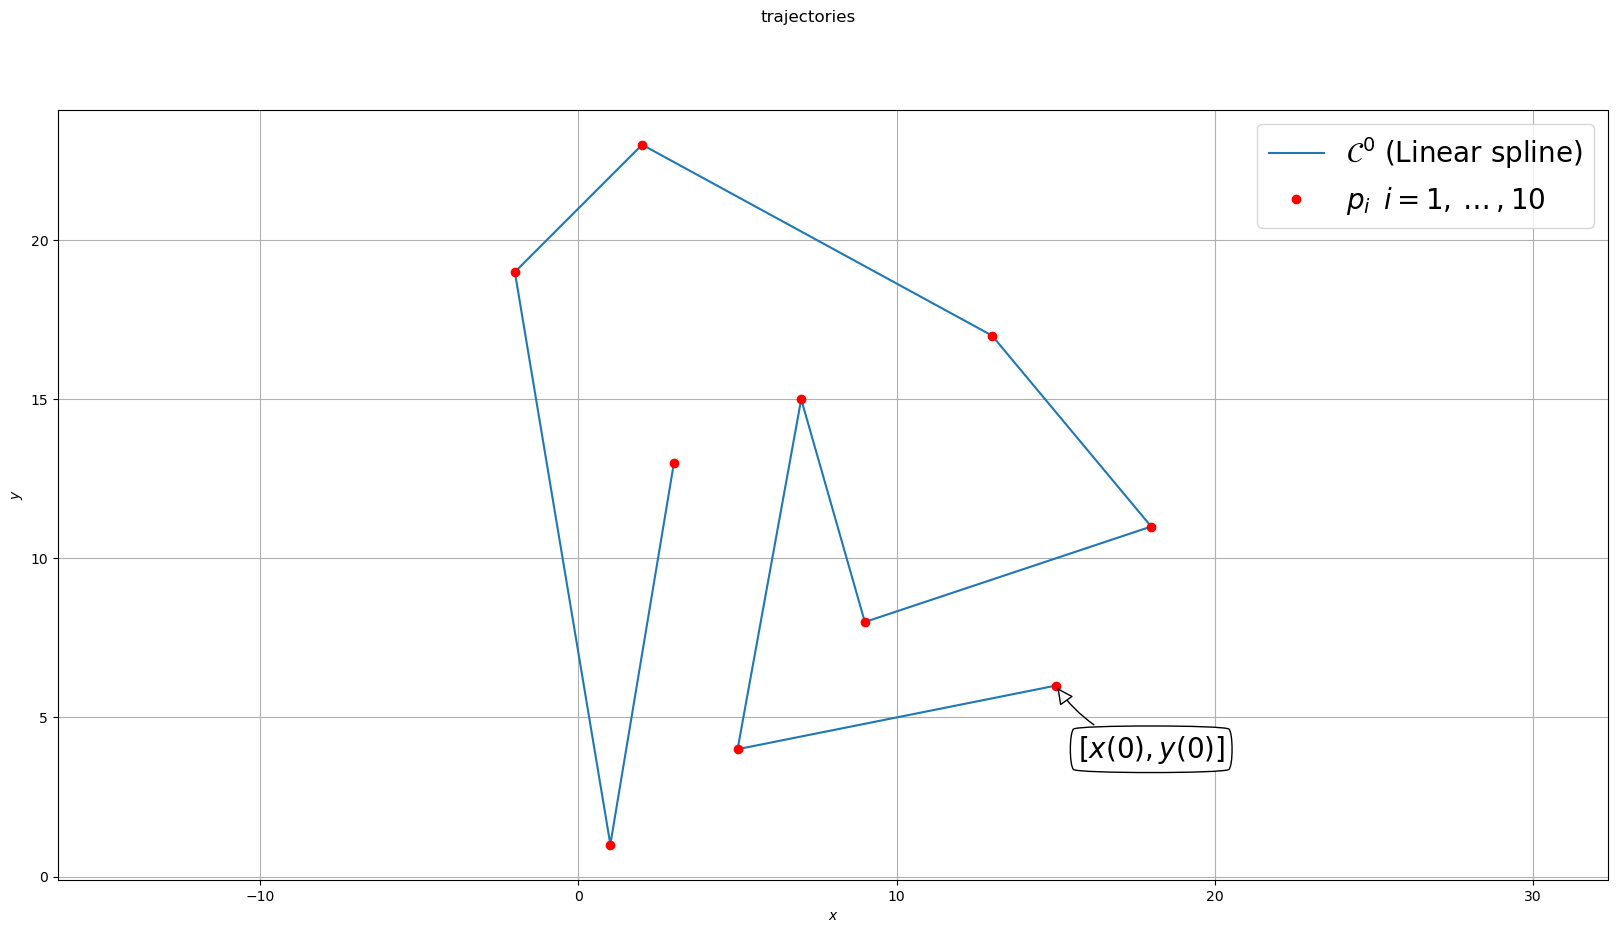

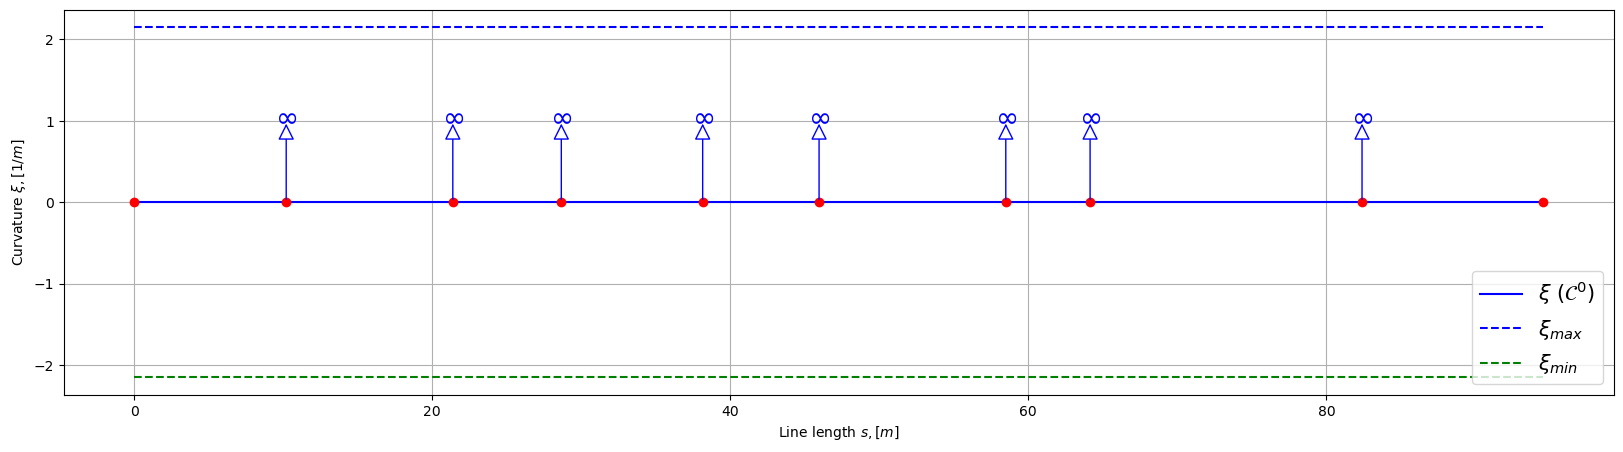

In [366]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax = [ax, 1]
C0, = ax[0].plot(data_rx[0], data_ry[0])

Points_init, = ax[0].plot(gx, gy, "or", label="Data points initial")

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(gx[0],gy[0]),
                  xytext=(gx[0]+3,gy[0]-2),
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].grid(True)
# ax[0].legend([C0,C2,Points_init], ['$\mathcal{C}^0$ (Linear spline)','$\mathcal{C}^2 $ (Cubic spline)',
#             '$p_{i}\,\,\,i=1,\dots,10$'],fontsize="20")
ax[0].legend([C0,Points_init], ['$\mathcal{C}^0$ (Linear spline)',
            '$p_{i}\,\,\,i=1,\dots,10$'],fontsize="20",loc='upper right')
ax[0].axis('equal')

plt.subplots(1,1,figsize = (20,5))
C0, = plt.plot(s, data_rk[0], "-b", label="curvature")
plt.plot(pplan_C0.s, np.zeros(len(pplan_C0.s)), "or")
for x,y,xnew,ynew in zip(pplan_C0.s[1:-1],np.zeros(len(pplan_C0.s[1:-1])), pplan_C0.s[1:-1],np.ones(len(pplan_C0.s[1:-1]))):
    plt.annotate("", xy=(x, y), xytext=(xnew,ynew),size=15, va="center", ha="center",
        arrowprops=dict(arrowstyle="<|-",mutation_scale=25,fc="w",color='blue'))
    plt.annotate("$\infty$", xy=(xnew, ynew+ynew*0.05),size=20, va="center", ha="center",color='blue')

k_max, = plt.plot(s, [1/Rmax]*len(s), "--b")
k_min, = plt.plot(s, [-1/Rmax]*len(s), "--g")
plt.grid(True)
plt.legend([C0,k_max,k_min],['$\\xi$ ($\mathcal{C}^0$)','$\\xi_{max}$','$\\xi_{min}$'],fontsize="15",
           loc='lower right')
plt.xlabel("Line length $s,[m]$")
plt.ylabel("Curvature $\\xi,[1/m]$")